# **Dogs and Cats image classification with Neural Network**
The objective of this project is to use Multi-layer Perceptron classifier to identify images of dogs and cats. The database used has 295 images of dogs and 295 images of cats.

The difficulty lies in the quality of the images. There are images with more than one pet, low brightness environment, bad framing and some even with humans.

The database was adapted from: https://www.kaggle.com/trishalsingh/dogs-vs-cats

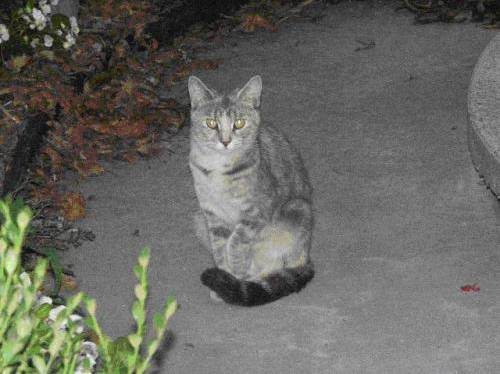

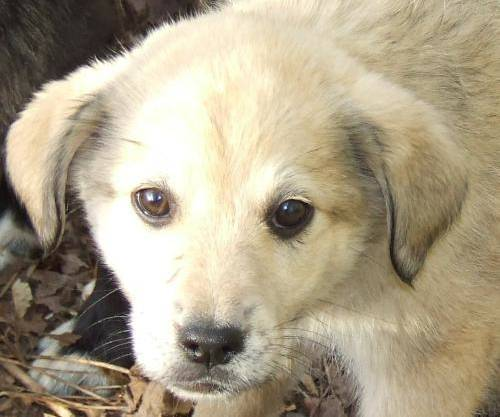



---
# **Upload of the data**
All libraries are imported, the database is loaded (through the google drive), the images are converted into RGB and Gray and saved as csv files.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Feature Extraction (Handcrafted and Deep Features)
import cv2
import numpy as np
import pandas as pd
import re
import math
from skimage import feature
from skimage.feature import hog
from imutils import paths
from google.colab.patches import cv2_imshow
import os

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

#Load Inception_v3 pretrained on ImageNet dataset
model = InceptionV3(include_top=False, weights='imagenet', pooling='avg', input_tensor=Input(shape=(299,299,3)))
#model = Xception(include_top=False, weights='imagenet', pooling='avg')

#general path
path='/content/drive/My Drive/Base/Base/'

#List of paths 
import os
file_list=[]
file_list.append(os.listdir(r"/content/drive/My Drive/Base/Base/Cats"))
file_list.append(os.listdir(r"/content/drive/My Drive/Base/Base/Dogs"))

class_names=['Cats', 'Dogs']
X = []
X_deep = []
y = []
names = []
fail = []
#Feature extraction
for classes_files, classe in zip (file_list, range(10)):
    #There are 295 images of each
    for i in range(295):
      name= str(path) + str(class_names[classe]) + str('/') + str(classes_files[i]) 
      imagem = cv2.imread(name)

      print(imagem.shape)
      altura, largura, _ = imagem.shape
    
#Convert the image to RGB and Gray    
      cinza = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
      rgb   = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

#Color Histograms
      r_histograma = cv2.calcHist([rgb], [0], None, [256], [0, 256])/(altura*largura)
      g_histograma = cv2.calcHist([rgb], [1], None, [256], [0, 256])/(altura*largura)
      b_histograma = cv2.calcHist([rgb], [2], None, [256], [0, 256])/(altura*largura)

#Local Binary Pattern (LBP)
      lbp = feature.local_binary_pattern(cinza, 59, 1, method="uniform")
      (lbp_histograma, _) = np.histogram(lbp.ravel(), bins=59, range=(0, 59))
      lbp_histograma = lbp_histograma.astype("float")
      lbp_histograma /= (lbp_histograma.sum())
    
#Hog (Histogram of Gradient - Direction)
      #Finding the images that causes error
      try:
        hg = hog(cinza, orientations=8, pixels_per_cell=(32, 32), cells_per_block=(8, 8), block_norm='L2-Hys')
      except ValueError:
        fail.append(name)
        continue

#Concatenate the handcrafted feature sets
      X_image = [lbp_histograma, hg, r_histograma, g_histograma, b_histograma]    
      X_image_aux = []
      for aux in X_image:
          X_image_aux = np.append(X_image_aux, np.ravel(aux))
    
      X_image = [i for i in X_image_aux]
      y.append(classe)
      X.append(X_image)
      
#Extract deep features using InceptionV3 pretrained model 
      imagem = cv2.imread(name)
      img = cv2.resize(imagem,(299,299))

      xd = image.img_to_array(img)
      xd = np.expand_dims(xd, axis=0)
      xd = preprocess_input(xd)
      deep_features = model.predict(xd)
      print(deep_features.shape)
      
      X_image_aux = []
      for aux in deep_features:
          X_image_aux = np.append(X_image_aux, np.ravel(aux))
    
      deep_features = [i for i in X_image_aux]
      names.append(name)

      X_deep.append(deep_features)
    print(fail)
          
#Saving the extracted features (deep) in a csv file
df1 = pd.DataFrame(X_deep)
df2 = pd.DataFrame(names)
df = pd.concat([df1, df2], axis=1)
df.to_csv('X_deep.csv', header=False, index=False)

#Saving the classes in a csv file
df_class = pd.DataFrame(y)
df_class.to_csv('y.csv', header=False, index=False)

Loading the CSV files

In [ ]:
#Labels
y = pd.read_csv('y.csv', header=None)
y=y.to_numpy()
y=np.ravel(y)
print(y.shape)

#Names
X = pd.read_csv('X_deep.csv', header=None)
X_names=X.iloc[:,2048].copy()

#Deep features
X=X.iloc[:,0:2048]
X=X.to_numpy()

(590,)




---


# **Creating the model**
Multi-layer Perceptron classifier is used with the Neural Network. MLPClassifier is capable of working with non-linear models and images.

But first, we have to Scale the dataset and split it in two: training and validation.

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn import  model_selection
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import preprocessing
#Ignore warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

#Scaling
scaler = preprocessing.MinMaxScaler().fit(X)
X = scaler.transform(X)

X = pd.DataFrame(X)
X = pd.concat([X, X_names], axis=1)

parameters = [
      {'solver': ['lbfgs', 'sgd', 'adam'], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 
       'hidden_layer_sizes': [4,7, (6,8)], 'learning_rate_init': [0.001,0.00001, 0.000001]},        
]

#Spliting the data (80% for training)
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

X_names=X_train.iloc[:,2048]
X_train=X_train.iloc[:,0:2048]
X_val=X_val.iloc[:,0:2048]

clf = MLPClassifier(random_state=10, max_iter=100, early_stopping=True)

# **GridSearch**
GridSearch is an excelent tool for optimization. It is capable of finding the best parameters for the MLPClassifier model. The idea is that the we should avoid unnecessary work and let the algorithm find the best tune.

In [ ]:
#GridSearch is used to find the best parameters for the MLPClassifier 
gs = GridSearchCV(clf, parameters, scoring = 'accuracy', cv=5, n_jobs=-1)
gs.fit(X_val, y_val)

#The best results are shown
from tabulate import tabulate
df=gs.cv_results_
print(tabulate(df, headers='keys', tablefmt='psql'))
print(gs.best_params_)

# **Results**
After the GridSearch is done finding the best tune, the MLPClassifier can run the model. 

In [ ]:
#Creating the prediction model with 10-fold cross-validation method
folds=10
clf=gs.best_estimator_
result = model_selection.cross_val_score(clf, X_train, y_train, cv=folds, n_jobs=5)
print("\nCross Validation Results %d folds:" % folds)
print("Mean accuracy: %.5f" % result.mean())
print("Std: %.5f" % result.std())

#Output of the model
output_prediction = model_selection.cross_val_predict(clf, X_train, y_train, cv=folds, n_jobs=5)
#Confusion Matrix
cm=confusion_matrix(y_train, output_prediction)
print("Confusion Matrix:")
print(cm)


Cross Validation Results 10 folds:
Mean accuracy: 0.98515
Std: 0.01913
Confusion Matrix:
[[234   2]
 [  5 231]]


The model has an accuracy of 98%. There were 7 wrong classifications: 5 dogs classified as cats and 2 cats classified as dogs. It is interesting to analyse these images in order to understand why the model failed.

# **Error analysis**
All the images that were incorrectly classified are shown.

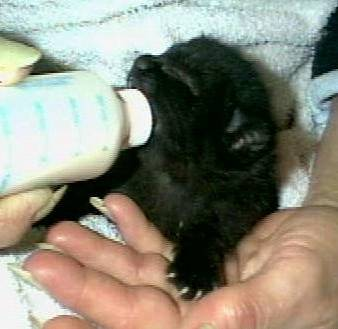

/content/drive/My Drive/Base/Base/Cats/1543.jpg


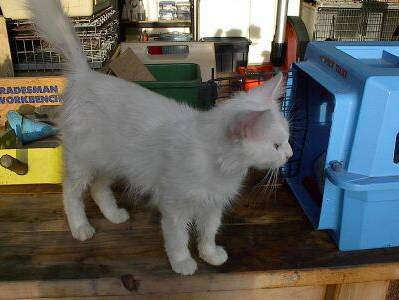

/content/drive/My Drive/Base/Base/Cats/2712.jpg


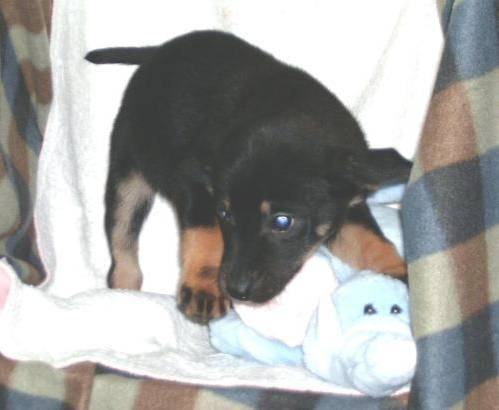

/content/drive/My Drive/Base/Base/Dogs/1629.jpg


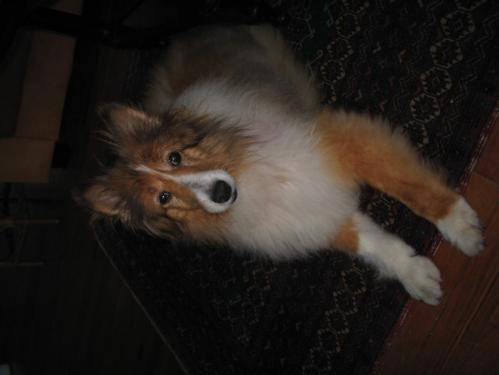

/content/drive/My Drive/Base/Base/Dogs/2047.jpg


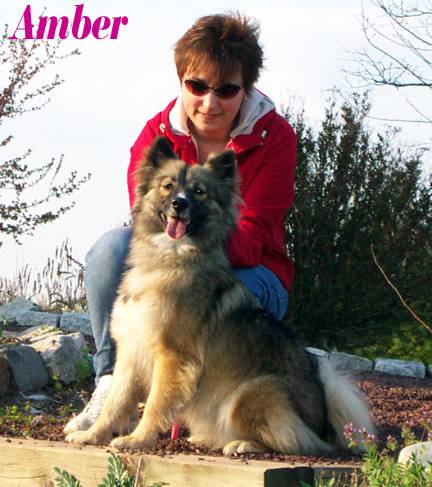

/content/drive/My Drive/Base/Base/Dogs/2844.jpg


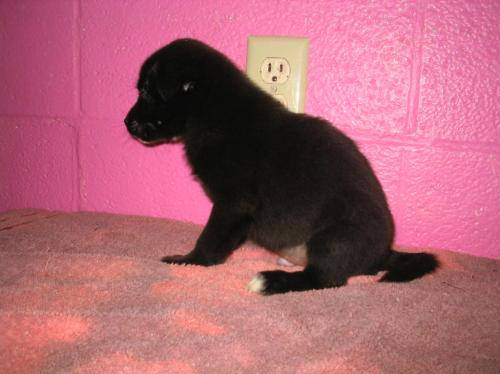

/content/drive/My Drive/Base/Base/Dogs/3034.jpg


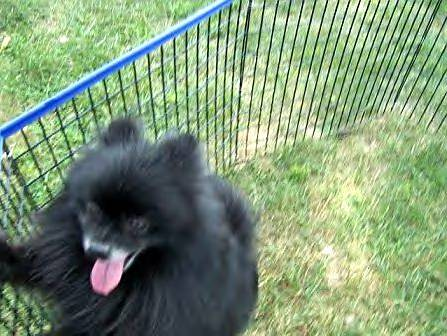

/content/drive/My Drive/Base/Base/Dogs/2166.jpg


In [ ]:
#Return the name of the failed classification images
for i in range(len(output_prediction)):
  if (output_prediction[i] != y_train[i]):
       
    ind=list(X_train.index.values)
    error=X_names.loc[[ind[i]]].values.tolist()
    error=str(error)
    remove=['[', ']', "'"]
    for char in remove:
      error=error.replace(char,"")
    img=cv2.imread(error)
    cv2_imshow(img)
    print(error)



The reasons for the wrong classifications can be due to bad framing, low resolution, low brightness and characteristics of the pet: dogs that looks like cats and cats that looks like dogs. Also, it is harder to distinguish puppies from kittens.

Nonetheless, the model performed well classificating the images.